# 문장 긍부정 분류 모델

## 필요 라이브러리 설치

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 29.9 MB/s 
     |████████████████████████████████| 596 kB 65.4 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install wandb -Uq

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 147 kB 64.5 MB/s 
     |████████████████████████████████| 181 kB 60.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


## 구글 드라이브 연동 및 작업 디렉토리 설정

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# your path
%cd /content/drive/MyDrive/Colab Notebooks/NLP_training_course/project/text_classification/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/NLP_training_course/project/text_classification


## import

In [4]:
import os
import pickle

import pandas as pd
import numpy as np

import torch
from torch import optim
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

from dataset import *
from trainer_test import Trainer

## 데이터 로드

In [4]:
# !python preprocess.py

In [ ]:
# model_name = "bert-base-multilingual-cased"

In [5]:
open_file = open(os.path.join("./data/train_pos.pkl"), "rb")
train_pos = pickle.load(open_file)
open_file.close()

open_file = open(os.path.join("./data/train_neg.pkl"), "rb")
train_neg = pickle.load(open_file)
open_file.close()

open_file = open(os.path.join("./data/dev_pos.pkl"), "rb")
dev_pos = pickle.load(open_file)
open_file.close()

open_file = open(os.path.join("./data/dev_neg.pkl"), "rb")
dev_neg = pickle.load(open_file)
open_file.close()

open_file = open(os.path.join("./data/test.pkl"), "rb")
test = pickle.load(open_file)
open_file.close()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)
test_dataset = SentimentTestDataset(tokenizer, test)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## wamdb 설정

In [6]:
# login
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# sweep_config 설정
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'optimizer': {
        'values': ['adamW']
        },
    "model":{
        'values': ['bert-base-uncased']
        }
    }
sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'values': [2,3]}
    })

parameters_dict.update({
    'learning_rate': {
        'values': [1e-6,1e-5,1e-4]
      },
    'batch_size': {
        'values': [128]}
        })

In [18]:
import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'parameters': {'batch_size': {'values': [128]},
                'epochs': {'values': [2, 3]},
                'learning_rate': {'values': [1e-06, 1e-05, 0.0001]},
                'model': {'values': ['bert-base-uncased']},
                'optimizer': {'values': ['adamW']}}}


In [20]:
sweep_id = wandb.sweep(sweep_config, project="test")

Create sweep with ID: 9y0jyz64
Sweep URL: https://wandb.ai/767476/test/sweeps/9y0jyz64


In [21]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        random_seed=42
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size,
                                                   shuffle=True, collate_fn=collate_fn_style,
                                                   pin_memory=True, num_workers=2)
        dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=64,
                                                 shuffle=False, collate_fn=collate_fn_style,
                                                 num_workers=2)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                                  shuffle=False, collate_fn=collate_fn_style_test,
                                                  num_workers=2)
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = build_model(config.model)
        model.to(device)
        optimizer = build_optimizer(config.optimizer)

        trainer = Trainer(train_loader=train_loader, dev_loader=dev_loader, test_loader=test_loader, model=model, lr=config.learning_rate, optimizer=optimizer, device=device)
        trainer.train(train_epoch=3, filename="test", use_wandb=True)

def build_optimizer(optimizer):
    if optimizer == "adamW":
        optimizer = AdamW

    elif optimizer == "adam":
        optimizer = optim.Adam

    return optimizer

def build_model(model = None):
    if model == "bert-base-uncased":
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

    return model

In [23]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: 1u7l95pl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	model: bert-base-uncased
wandb: 	optimizer: adamW


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Acc for model which have lower valid loss:  0.95875


Eval:  97%|█████████▋| 61/63 [00:03<00:00, 18.80it/s]
                                                     

Acc for model which have lower valid loss:  0.96375


Epoch 0:  11%|█         | 379/3463 [01:59<15:37,  3.29batch/s, loss=0.113]wandb: Ctrl + C detected. Stopping sweep.


## best model

In [9]:
trainer = Trainer(train_loader=train_loader, dev_loader=dev_loader, test_loader=test_loader, model=model, lr=learning_rate, optimizer=AdamW, device=device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Eval:  98%|█████████▊| 62/63 [00:03<00:00, 18.80it/s]
                                                     

Acc for model which have lower valid loss:  0.97075


Eval:  98%|█████████▊| 62/63 [00:03<00:00, 18.89it/s]
                                                     

Acc for model which have lower valid loss:  0.9745


Eval:  97%|█████████▋| 61/63 [00:03<00:00, 18.88it/s]
                                                     

Acc for model which have lower valid loss:  0.97675


Eval:  98%|█████████▊| 62/63 [00:03<00:00, 19.01it/s]
                                                     

Acc for model which have lower valid loss:  0.97725


Eval:  98%|█████████▊| 62/63 [00:03<00:00, 18.66it/s]
                                                     

Acc for model which have lower valid loss:  0.98


Eval:  98%|█████████▊| 62/63 [00:03<00:00, 18.77it/s]
                                                     

Acc for model which have lower valid loss:  0.98275


Epoch 2: 100%|██████████| 3463/3463 [16:54<00:00,  3.41batch/s, loss=0.0103]


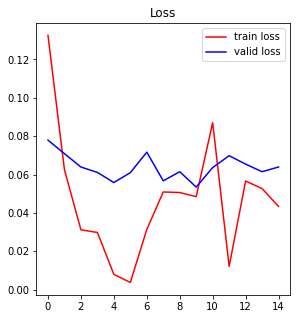

In [10]:
trainer.train(train_epoch=3, filename="test")

In [14]:
predictions=trainer.test()


Test:  97%|█████████▋| 31/32 [00:01<00:00, 32.69it/s]
                                                     

In [15]:
test_df = pd.read_csv('./data/test_no_label.csv')
test_df['Category'] = predictions
test_df.to_csv('./submission/submission_test.csv', index=False)

In [ ]:
test_df

,Id,Category
0,it 's a whole new experience and new flavors e...,1
1,so disappointing from an old favorite .,0
2,it is the most authentic thai in the valley .,1
3,do not sign a lease with these people .,0
4,i was nervous and she made me feel so comforta...,1
...,...,...
995,the food here is delicious .,1
996,we 'll certainly be back !,1
997,the building itself looks abandoned .,0
998,if i could give zero stars i def would .,0
